Read the train and test splits, combine them and make better splits to help training networks easier.

In [147]:
from collections import Counter
from sklearn.model_selection import train_test_split

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse", 
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1,random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (2733):
	['drinking_203.jpg', 'smoking_048.jpg', 'running_099.jpg', 'jumping_186.jpg', 'smoking_205.jpg', 'riding_a_bike_090.jpg', 'climbing_184.jpg', 'throwing_frisby_078.jpg', 'applauding_185.jpg', 'throwing_frisby_131.jpg', 'running_241.jpg', 'riding_a_horse_229.jpg', 'throwing_frisby_009.jpg', 'climbing_126.jpg', 'waving_hands_188.jpg', 'shooting_an_arrow_062.jpg', 'riding_a_horse_191.jpg', 'applauding_087.jpg', 'applauding_074.jpg', 'riding_a_bike_181.jpg', 'running_091.jpg', 'riding_a_bike_188.jpg', 'riding_a_bike_027.jpg', 'throwing_frisby_035.jpg', 'climbing_022.jpg', 'applauding_095.jpg', 'waving_hands_024.jpg', 'running_225.jpg', 'climbing_224.jpg', 'riding_a_bike_108.jpg', 'running_050.jpg', 'jumping_089.jpg', 'pouring_liquid_089.jpg', 'climbing_087.jpg', 'applauding_143.jpg', 'jumping_069.jpg', 'waving_hands_039.jpg', 'smoking_019.jpg', 'drinking_030.jpg', 'running_189.jpg', 'climbing_159.jpg', 'climbing_221.jpg', 'drinking_162.jpg', 'drinking_210.jpg', 'riding_

In [148]:
import os
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
      # extract only the relevant classes for the assignment.
      os.system("mkdir -p video_data/" + foldername)
      os.system("unrar e video_data/"+ files + " video_data/"+foldername)

Load data into dataloaders with necessary transforms

In [149]:
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch
import transforms as T

torch.manual_seed(97)
num_frames = 16
clip_steps = 2
batch_size = 16

transform = transforms.Compose([ T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 T.RandomCrop((172, 172))])
transform_test = transforms.Compose([                           
                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 T.CenterCrop((172, 172))])


hmdb51_train = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames, frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=True,
                                                transform=transform, num_workers=2)

hmdb51_test = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames, frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=False,
                                                transform=transform_test, num_workers=2)

train_loader = DataLoader(hmdb51_train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(hmdb51_test, batch_size=batch_size, shuffle=False)

100.0%
/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/torchvision/datasets/video_utils.py:223: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(
100.0%


Processing Stanford 40 data

In [150]:
train_set, val_set = train_test_split(train_files, test_size=0.1, random_state=42, stratify=train_labels)
train_labs = ['_'.join(name.split('_')[:-1]) for name in train_set]
val_labs = ['_'.join(name.split('_')[:-1]) for name in val_set]
len(train_set), len(val_set)

(2459, 274)

In [151]:
import cv2 as cv

In [152]:
def preprocess_image(image, size=112):
    # Load the image
    height, width = image.shape[:2]
    aspect_ratio = float(width) / float(height)

    # # calculating the new dimensions for 28x28 while maintaining the aspect ratio
    # if aspect_ratio > 1:
    #     new_width = size
    #     new_height = int(round(new_width / aspect_ratio))
    # else:
    #     new_height = size
    #     new_width = int(round(new_height * aspect_ratio))

    # Crop the image to a square
    if height > width:
        offset = (height - width) // 2
        image = image[offset:offset+width, :]
    else:
        offset = (width - height) // 2
        image = image[:, offset:offset+height]

    # resizing the image using the calculated dimensions
    resized_img = cv.resize(image, (size, size), interpolation=cv.INTER_AREA)
    #
    # # adding padding to make the image 28x28
    # padding_x1 = (size - new_width) // 2
    # padding_y1 = (size - new_height) // 2
    # padding_x2 = size - new_width - padding_x1
    # padding_y2 = size - new_height - padding_y1
    #
    # a = cv.copyMakeBorder(resized_img, padding_y1, padding_y2, padding_x1, padding_x2, cv.BORDER_WRAP)
    return resized_img
    # return resized_img

In [153]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder


x_train = []
for i in range(len(train_set)):
    img = preprocess_image(cv.imread(f'Stanford40/JPEGImages/{train_set[i]}'))
    # switch to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    x_train.append(img)

x_train = np.array(x_train)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labs)
y_train = to_categorical(y_train)

x_val = []
for i in range(len(val_set)):
    img = preprocess_image(cv.imread(f'Stanford40/JPEGImages/{val_set[i]}'))
    x_val.append(img)

x_val = np.array(x_val)

label_encoder = LabelEncoder()
y_val = label_encoder.fit_transform(val_labs)
y_val = to_categorical(y_val)

x_test = []
for i in range(len(test_files)):
    img = preprocess_image(cv.imread(f'Stanford40/JPEGImages/{test_files[i]}'))
    x_test.append(img)
x_test = np.array(x_test)

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_labels)
y_test = to_categorical(y_test)

# Building Stanford CNN, training and testing

In [154]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LayerNormalization, BatchNormalization, Conv3D
from keras.utils import plot_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [155]:
def plot_loss(hist, model_name):
    # Function to plot both loss and accuracy on train and validation
    plt.plot(hist.history['loss'], label="Train")
    plt.plot(hist.history['val_loss'], label="Validation")
    plt.title(f"{model_name} train and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"./Losses/{model_name}.png")
    plt.show()
    plt.plot(hist.history['accuracy'], label="Train")
    plt.plot(hist.history['val_accuracy'], label="Validation")
    plt.title(f"{model_name} train and validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"./Losses/{model_name}_accuracy.png")
    plt.show()
    return

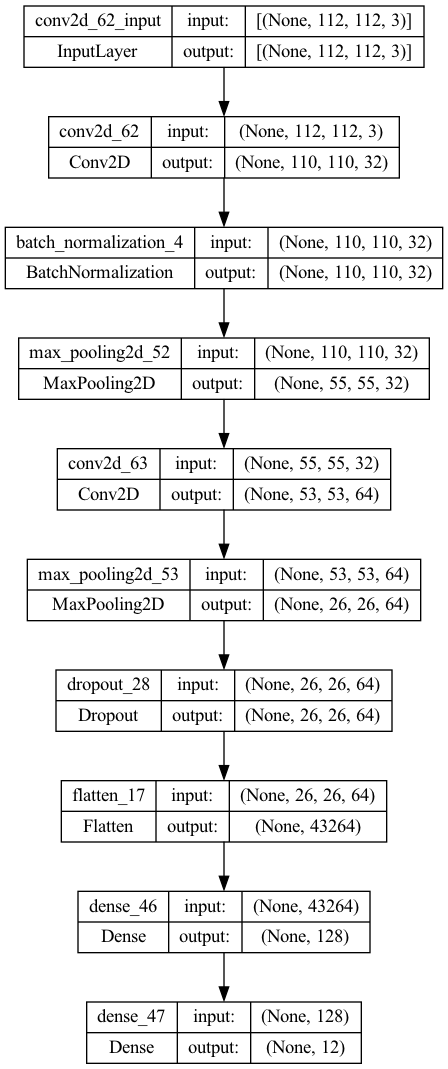

In [156]:
input_shape = (112, 112, 3) # to decide
num_classes = 12

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, show_shapes=True, show_layer_names=True)

In [157]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15)

Epoch 1/15
77/77 [==============================] - 5s 47ms/step - loss: 4.4484 - accuracy: 0.0801 - val_loss: 2.5329 - val_accuracy: 0.0547
Epoch 2/15
77/77 [==============================] - 3s 33ms/step - loss: 2.4771 - accuracy: 0.0895 - val_loss: 2.4586 - val_accuracy: 0.1131
Epoch 3/15
77/77 [==============================] - 3s 34ms/step - loss: 2.4434 - accuracy: 0.1090 - val_loss: 2.4220 - val_accuracy: 0.1533
Epoch 4/15
77/77 [==============================] - 3s 33ms/step - loss: 2.4045 - accuracy: 0.1427 - val_loss: 2.4515 - val_accuracy: 0.1204
Epoch 5/15
77/77 [==============================] - 3s 33ms/step - loss: 2.3728 - accuracy: 0.1484 - val_loss: 2.4275 - val_accuracy: 0.1314
Epoch 6/15
77/77 [==============================] - 3s 33ms/step - loss: 2.3126 - accuracy: 0.1745 - val_loss: 2.4673 - val_accuracy: 0.1131
Epoch 7/15
77/77 [==============================] - 3s 33ms/step - loss: 2.2608 - accuracy: 0.1883 - val_loss: 2.3953 - val_accuracy: 0.1460
Epoch 8/15
77

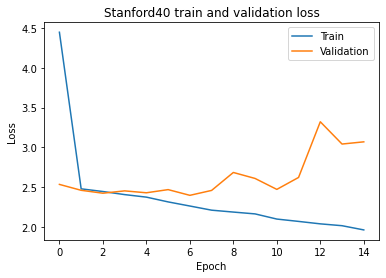

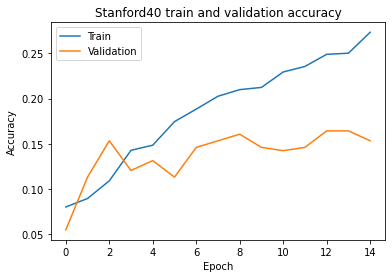

In [158]:
plot_loss(history, "Stanford40")

In [159]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

10/10 - 0s - loss: 3.0963 - accuracy: 0.1579 - 259ms/epoch - 26ms/step

Test accuracy: 0.15789473056793213


# Processing HMDB51 data

In [160]:
# splitting train 90-10 for validation
train_size = int(len(train_loader.dataset) * 0.9)
val_size = int(len(train_loader.dataset)) - train_size
train_subset, val_subset = random_split(train_loader.dataset, lengths = [train_size, val_size], generator=torch.Generator().manual_seed(42))

# reload data using DataLoaders
training_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

In [161]:
len(training_loader.dataset.indices), len(val_loader.dataset.indices)

(2680, 298)

In [162]:
# to iterate videos 
for video, _, label in training_loader.dataset:
    print(video.shape) # 3 channels, 16 frames, 172x172
    print(label)
    break


torch.Size([3, 16, 172, 172])
9


/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [163]:
x_train_hmdb51 = []
y_train_hmdb51 = []
train_data = training_loader.dataset
for video, _, label in train_data:
    middle_frame = np.array(video[:, 8, :, :])
    # change first dimension and third dimension
    middle_frame = np.moveaxis(middle_frame, 0, 2)
    middle_frame = preprocess_image(middle_frame)

    x_train_hmdb51.append(middle_frame)
    y_train_hmdb51.append(label)
x_train_hmdb51 = np.array(x_train_hmdb51)
y_train_hmdb51 = to_categorical(y_train_hmdb51)


x_val_hmdb51 = []
y_val_hmdb51 = []
val_data = val_loader.dataset
for video, _, label in val_data:
    middle_frame = np.array(video[:, 8, :, :])
    # change first dimension and third dimension
    middle_frame = np.moveaxis(middle_frame, 0, 2)
    middle_frame = preprocess_image(middle_frame)

    x_val_hmdb51.append(middle_frame)
    y_val_hmdb51.append(label)
x_val_hmdb51 = np.array(x_val_hmdb51)
y_val_hmdb51 = to_categorical(y_val_hmdb51)

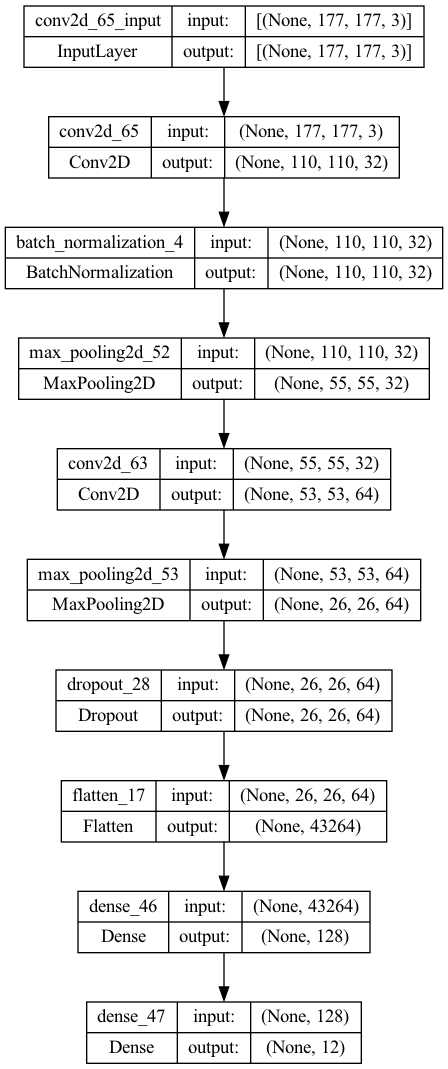

In [170]:
input_shape = (177, 177, 3)

for layer in model.layers[:3]:
    layer.trainable = False
new_model = Sequential()
new_model.add(Conv2D(32, (68, 68), activation='relu', input_shape=input_shape))
for layer in model.layers[1:]:
    new_model.add(layer)
plot_model(new_model, show_shapes=True, show_layer_names=True)

In [171]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.0005), metrics=['accuracy'])
history_transfer = model.fit(x_train_hmdb51, y_train_hmdb51, validation_data=(x_val_hmdb51, y_val_hmdb51), epochs=15)

Epoch 1/15
84/84 [==============================] - 3s 28ms/step - loss: 2.1942 - accuracy: 0.2597 - val_loss: 2.1520 - val_accuracy: 0.2550
Epoch 2/15
84/84 [==============================] - 2s 21ms/step - loss: 2.1824 - accuracy: 0.2597 - val_loss: 2.1395 - val_accuracy: 0.2550
Epoch 3/15
84/84 [==============================] - 2s 20ms/step - loss: 2.1716 - accuracy: 0.2597 - val_loss: 2.1282 - val_accuracy: 0.2550
Epoch 4/15
84/84 [==============================] - 2s 20ms/step - loss: 2.1618 - accuracy: 0.2597 - val_loss: 2.1175 - val_accuracy: 0.2550
Epoch 5/15
84/84 [==============================] - 2s 21ms/step - loss: 2.1528 - accuracy: 0.2597 - val_loss: 2.1077 - val_accuracy: 0.2550
Epoch 6/15
84/84 [==============================] - 2s 20ms/step - loss: 2.1445 - accuracy: 0.2597 - val_loss: 2.0987 - val_accuracy: 0.2550
Epoch 7/15
84/84 [==============================] - 2s 21ms/step - loss: 2.1370 - accuracy: 0.2597 - val_loss: 2.0906 - val_accuracy: 0.2550
Epoch 8/15
84

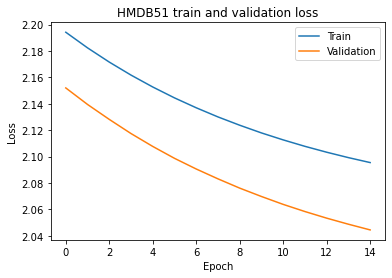

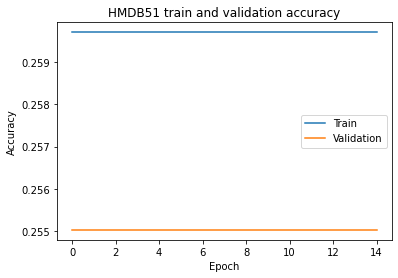

In [172]:
plot_loss(history_transfer, "HMDB51")

In [167]:
x_test_hmdb51 = []
y_test_hmdb51 = []
test_data = test_loader.dataset
for video, _, label in test_data:
    middle_frame = np.array(video[:, 8, :, :])
    # change first dimension and third dimension
    middle_frame = np.moveaxis(middle_frame, 0, 2)
    middle_frame = preprocess_image(middle_frame)

    x_test_hmdb51.append(middle_frame)
    y_test_hmdb51.append(label)
x_test_hmdb51 = np.array(x_test_hmdb51)
y_test_hmdb51 = to_categorical(y_test_hmdb51)

/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [168]:
test_loss, test_acc = model.evaluate(x_test_hmdb51, y_test_hmdb51, verbose=2)

print('\nTest accuracy:', test_acc)

36/36 - 1s - loss: 2.2545 - accuracy: 0.1636 - 681ms/epoch - 19ms/step

Test accuracy: 0.1635555624961853


In [169]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

10/10 - 0s - loss: 3.1664 - accuracy: 0.1447 - 346ms/epoch - 35ms/step

Test accuracy: 0.14473684132099152
